## Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# for exploratory data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# needed to split the data
from sklearn.model_selection import train_test_split
from IPython.display import display
from custom_code.eda import plot_default_rate

## Constants

In [3]:
DATA_PATH = "./data/good-bad-customers-data.csv"
LAYOUT_PATH = "./data/good-bad-customers-layout.csv"
SEED = 42
TEST_SIZE = 0.2
TARGET_COLUMN = "f_3pva18m"
ID_COLUMN = "N_SOLICITUD"
RECORD_DATE_COLUMN = "mes_solicitud"

## Reading the data

In [4]:
df = pd.read_csv(DATA_PATH)
df_layout = pd.read_csv(LAYOUT_PATH)

# reformating
df.drop(ID_COLUMN, axis=1 ,inplace=True)
# we are only interested in the respective month
df[RECORD_DATE_COLUMN] = df[RECORD_DATE_COLUMN].astype(str).str.replace("-", "").str[:-2]

### Exploratory Data Analysis

In [5]:
print("="*120)
print("Top ten variables with more null values:")
print("="*120)
display(df.isna().mean().sort_values(ascending=False).head(10))

Top ten variables with more null values:


razon_monto_apagar_saldo_vencido_ban_all                         0.940856
razon_monto_apagar_saldo_vencido_open                            0.875093
razon_maximo_saldo_maxima_mora_maximo_credito_masalto_ban_all    0.414113
r_sumhhda_sumhc_ban_all                                          0.414113
r_sumhhda_sumhc_open                                             0.227821
razon_maximo_saldo_maxima_mora_maximo_credito_masalto_open       0.227821
razon_saldo_vencido_saldo_actual_ban_all                         0.191203
razon_monto_apagar_saldo_actual_ban_all                          0.188961
utilizacion_maximo_limite_ban_all                                0.072809
razon_monto_apagar_saldo_actual_open                             0.056582
dtype: float64

Data types:

In [6]:
df.dtypes.reset_index(name="dtype").groupby("dtype").size().reset_index(name="counting")

,dtype,counting
0,int64,1
1,float64,52
2,object,1


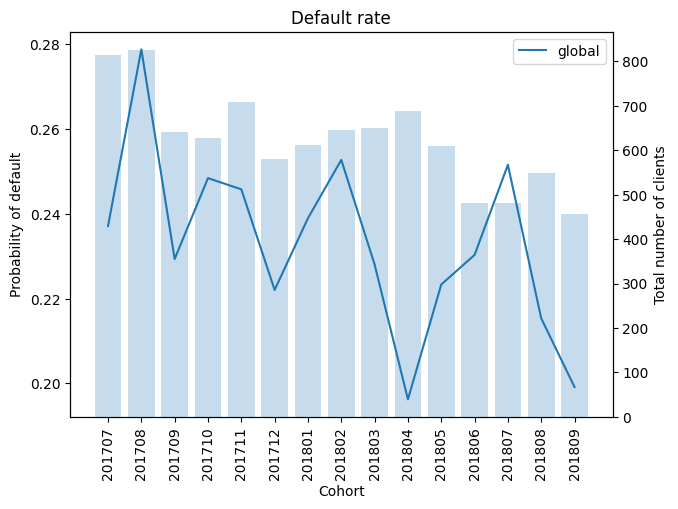

,mes_solicitud,default_rate,counting,reversed_cumulated_counting
0,201707,0.237101,814,1.000000
1,201708,0.278788,825,0.913099
2,201709,0.229329,641,0.825024
3,201710,0.248408,628,0.756592
4,201711,0.245763,708,0.689548
5,201712,0.222031,581,0.613964
6,201801,0.238953,611,0.551938
7,201802,0.252713,645,0.486709
8,201803,0.228043,649,0.417850
9,201804,0.196221,688,0.348564


The percentage of bad clients is  23.47%.


In [7]:
print("="*120)
df_default_rate_summary = plot_default_rate(df, TARGET_COLUMN, RECORD_DATE_COLUMN, (7, 5), "global")
print("="*120)
display(df_default_rate_summary)
print("="*120)
print(f"The percentage of bad clients is {100 * df[TARGET_COLUMN].mean() : .2f}%.")
print("="*120)

### Train, test and OOT

Before moving forward, we split the data into three datasets:

    1. OOT: Used to simulate performance in a production evironment. It can help us to capture whether our model worsens its predictions over time.
    2. Train: Used to train the model.
    3. Test: Used to estimate the model performance over a dataset independent to the train one.

For this task, we will be using the set of datapoints corresponding to 201808 and 201809 as OOT. From the complement of it we will be taking the train and test data, using stratified sampling.

In [8]:
mask_oot = df[RECORD_DATE_COLUMN].isin(["201808", "201809"])
df_oot = df[mask_oot].copy()
df_train_test = df[~mask_oot].copy()

X_train_test = df_train_test.drop(TARGET_COLUMN, axis=1)
y_train_test = df_train_test[TARGET_COLUMN].values

dummy_stratify = X_train_test[RECORD_DATE_COLUMN] + "_" + y_train_test.astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X_train_test, y_train_test, stratify=dummy_stratify, test_size=TEST_SIZE, random_state=SEED)

df_train = X_train.copy()
df_train[TARGET_COLUMN] = y_train

df_test = X_test.copy()
df_test[TARGET_COLUMN] = y_test

Default rate in the train data set versus globally


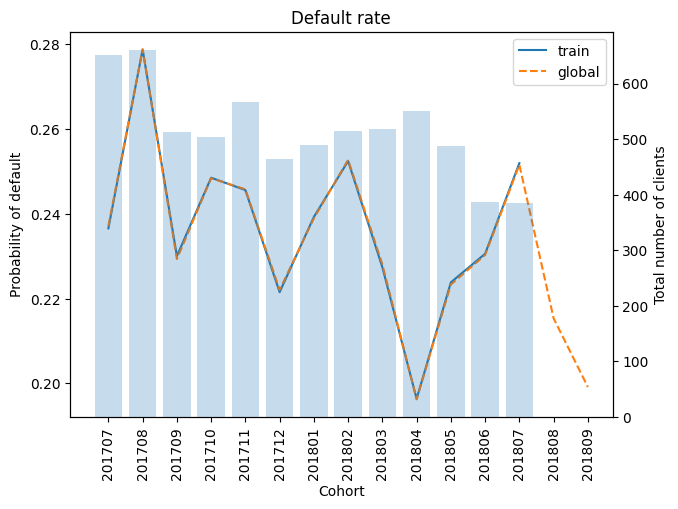

In [9]:
df_train = X_train.copy()
df_train[TARGET_COLUMN] = y_train

print("="*120)
print("Default rate in the train data set versus globally")
print("="*120)
df_default_rate_summary = plot_default_rate(df_train, TARGET_COLUMN, RECORD_DATE_COLUMN, (7, 5), "train", df, "global")

### Saving the data

In [10]:
df_oot.to_csv("./data/df_oot.csv", index=False)
df_train.to_csv("./data/df_train.csv", index=False)
df_test.to_csv("./data/df_test.csv", index=False)